# How to Build a Simple Image Recognition System with TensorFlow 

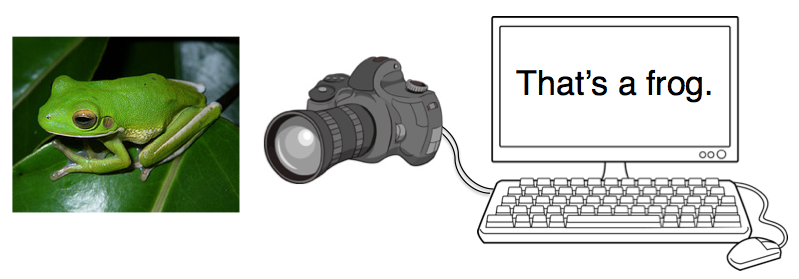

In [1]:
from IPython.display import Image
Image("/home/vimal/Desktop/sem3/visual/image-classification-CIFAR10-tf-master/frog_title_image.png")


Image recognition: Give the computer the opportunity to learn from experience, similar to how we humans learn from experience too.

# Image classification and the CIFAR-10 dataset

When presented with an image (with specific image dimensions), our system should analyze it and assign a single label to it. It can choose from a fixed number of labels, each being a category describing the image’s content. Our goal is to pick the correct category as often as possible. This task is called image classification.

We will use a standardized dataset called CIFAR-10. CIFAR-10 consists of 60000 images. There are 10 different categories and 6000 images per category. Each image has a size of only 32 by 32 pixels. 

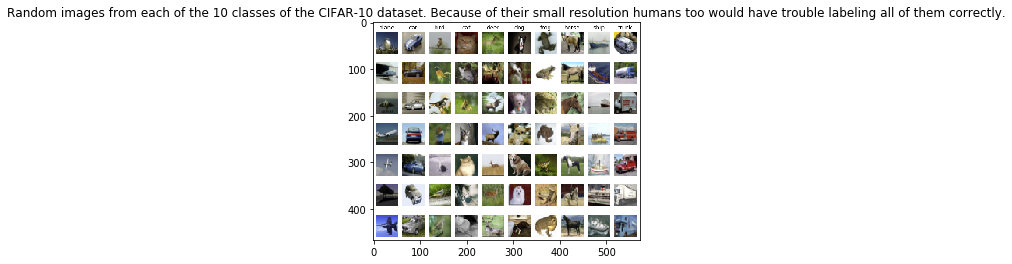

In [2]:
import matplotlib.pyplot as plt
from scipy.misc import imread
img = imread('/home/vimal/Desktop/sem3/visual/image-classification-CIFAR10-tf-master/CIFAR-10_examples.png')
plt.imshow(img)
plt.title('Random images from each of the 10 classes of the CIFAR-10 dataset. Because of their small resolution humans too would have trouble labeling all of them correctly.')
plt.show()

# Supervised Learning

We’re defining a general mathematical model of how to get from input image to output label. The model’s concrete output for a specific image then depends not only on the image itself, but also on the model’s internal parameters. These parameters are not provided by us, instead they are learned by the computer.

We start by defining a model and supplying starting values for its parameters. Then we feed the image dataset with its known and correct labels to the model. That’s the training stage. During this phase the model repeatedly looks at training data and keeps changing the values of its parameters. The goal is to find parameter values that result in the model’s output being correct as often as possible. This kind of training, in which the correct solution is used together with the input data, is called supervised learning.

After the training has finished, the model’s parameter values don’t change anymore and the model can be used for classifying images which were not part of its training dataset.

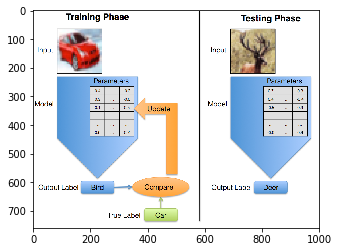

In [3]:
img1 = imread('/home/vimal/Desktop/sem3/visual/image-classification-CIFAR10-tf-master/train_test_phases.png')
plt.imshow(img1)
plt.show()

# TensorFlow

TensorFlow is a open source software library for machine learning, which was released by Google in 2015. We use it to do the numerical heavy lifting for our image classification model.

Building the Model, a Softmax Classifier:

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf
import time
import data_helpers

The future-Statements should be present in all TensorFlow Python files to ensure compatability with both Python 2 and 3 according to the TensorFlow style guide.

Then we are importing TensorFlow, numpy for numerical calculations, and the time module. data_helpers.py contains functions that help with loading and preparing the dataset.

In [2]:
beginTime = time.time()

# Parameter definitions
batch_size = 100
learning_rate = 0.005
max_steps = 1000

# Prepare data
data_sets = data_helpers.load_data()

Reading the data is in a separate data_helpers.py file

One thing is important to mention though. load_data() is splitting the 60000 images into two parts. The bigger part contains 50000 images. This training set is what we use for training our model. The other 10000 images are called test set.

The concept of a model learning the specific features of the training data and possibly neglecting the general features, which we would have preferred for it to learn is called overfitting

load_data() returns a dictionary containing

    images_train: the training dataset as an array of 50000 by 3072 (= 32 pixels x 32 pixels x 3 color channels) values
    labels_train: 50000 labels for the training set (each a number between 0 nad 9 representing which of the 10 class the training image belongs to)
    images_test: test set (10000 by 3072)
    labels_test: 10000 labels for the test set
    classes: 10 text labels for translating the numerical class value into a word (0 for ‘plane’, 1 for ‘car’, etc.)


Define input placeholders

In [3]:
images_placeholder = tf.placeholder(tf.float32, shape=[None, 3072])
labels_placeholder = tf.placeholder(tf.int64, shape=[None])

The actual numerical computations are being handled by TensorFlow, which uses a fast and efficient C++ backend to do this. TensorFlow wants to avoid repeatedly switching between Python and C++ because that would slow down our calculations. The common workflow is therefore to first define all the calculations we want to perform by building a so-called TensorFlow graph. During this stage no calculations are actually being performed, we are merely setting the stage. Only afterwards we run the calculations by providing input data and recording the results.

So let’s start defining our graph. We first describe the way our input data for the TensorFlow graph looks like by creating placeholders. These placeholders do not contain any actual data, they just specify the input data’s type and shape.

For our model, we’re first defining a placeholder for the image data, which consists of floating point values (tf.float32). The shape argument defines the input dimensions. 

We will provide multiple images at the same time, but we want to stay flexible about how many images we actually provide. The first dimension of shape is therefore None, which means the dimension can be of any length. The second dimension is 3072, the number of floating point values per image.

The placeholder for the class label information contains integer values (tf.int64), one value in the range from 0 to 9 per image. Since we’re not specifying how many images we’ll input, the shape argument is [None].

In [4]:
# Define variables (these are the values we want to optimize)
weights = tf.Variable(tf.zeros([3072, 10]))
biases = tf.Variable(tf.zeros([10]))

weights and biases are the variables we want to optimize.

Our input consists of 3072 floating point numbers and the desired output is one of 10 different integer values.

Our image is represented by a 3072-dimensional vector. If we multiply this vector with a 3072 x 10 matrix of weights, the result is a 10-dimensional vector containing exactly the weighted sums we are interested in.

The actual values in the 3072 x 10 matrix are our model parameters. If they are random/garbage our output will be random/garbage. That’s where the training data comes into play. By looking at the training data we want the model to figure out the parameter values by itself.

The bias does not directly interact with the image data and is simply added to the weighted sums. The bias can be seen as a kind of starting point for our scores. 

In [5]:
# Define the classifier's result
logits = tf.matmul(images_placeholder, weights) + biases

This is where the prediction takes place. We’ve arranged the dimensions of our vectors and matrices in such a way that we can evaluate multiple images in a single step. The result of this operation is a 10-dimensional vector for each input image.

In [6]:
# Define the loss function
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=labels_placeholder))

The process of arriving at good values for the weights and bias parameters is called training and works as follows: First, we input training data and let the model make a prediction using its current parameter values. This prediction is then compared to the correct class labels. The numerical result of this comparison is called loss. The smaller the loss value, the closer the predicted labels are to the correct labels and vice versa. We want to model to minimize the loss, so that its predictions are close to the true labels. But before we look at the loss minimization, let’s take a look at how the loss is calculated.

The scores calculated in the previous step, stored in the logits variable, contains arbitrary real numbers. We can transform these values into probabilities (real values between 0 and 1 which sum to 1) by applying the softmax function, which basically squeezes its input into an output with the desired attributes. The relative order of its inputs stays the same, so the class with the highest score stays the class with the highest probability. The softmax function’s output probability distribution is then compared to the true probability distribution, which has a probability of 1 for the correct class and 0 for all other classes. We use a measure called cross-entropy to compare the two distributions. The smaller the cross-entropy, the smaller the difference between the predicted probability distribution and the correct probability distribution. This value represents the loss in our model.

TensorFlow handles all the details for us by providing a function that does exactly what we want. We compare logits, the model’s predictions, with labels_placeholder, the correct class labels. The output of sparse_softmax_cross_entropy_with_logits() is the loss value for each input image. We then calculate the average loss value over the input images.

In [7]:
# Define the training operation
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

Auto-differentiation is the technique to change parameter values to minimize the loss.(it can calculate the gradient of the loss with respect to the parameter values.)

In [8]:
# Operation comparing prediction with true label
correct_prediction = tf.equal(tf.argmax(logits, 1), labels_placeholder)

# Operation calculating the accuracy of our predictions
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

These two lines measure the model’s accuracy. argmax of logits along dimension 1 returns the indices of the class with the highest score, which are the predicted class labels. The labels are then compared to the correct class labels by tf.equal(), which returns a vector of boolean values. The booleans are cast into float values (each being either 0 or 1), whose average is the fraction of correctly predicted images.

In [9]:
# -----------------------------------------------------------------------------
# Run the TensorFlow graph
# -----------------------------------------------------------------------------
with tf.Session() as sess:
  # Initialize variables
  sess.run(tf.global_variables_initializer())

  # Repeat max_steps times
  for i in range(max_steps):

    # Generate input data batch
    indices = np.random.choice(data_sets['images_train'].shape[0], batch_size)
    images_batch = data_sets['images_train'][indices]
    labels_batch = data_sets['labels_train'][indices]

    # Periodically print out the model's current accuracy
    if i % 100 == 0:
      train_accuracy = sess.run(accuracy, feed_dict={images_placeholder: images_batch, labels_placeholder: labels_batch})
      print('Step {:5d}: training accuracy {:g}'.format(i, train_accuracy))

    # Perform a single training step
    sess.run(train_step, feed_dict={images_placeholder: images_batch,
      labels_placeholder: labels_batch})

  # After finishing the training, evaluate on the test set
  test_accuracy = sess.run(accuracy, feed_dict={
    images_placeholder: data_sets['images_test'],
    labels_placeholder: data_sets['labels_test']})
  print('Test accuracy {:g}'.format(test_accuracy))

endTime = time.time()
print('Total time: {:5.2f}s'.format(endTime - beginTime))

Step     0: training accuracy 0.1
Step   100: training accuracy 0.27
Step   200: training accuracy 0.32
Step   300: training accuracy 0.22
Step   400: training accuracy 0.2
Step   500: training accuracy 0.4
Step   600: training accuracy 0.36
Step   700: training accuracy 0.3
Step   800: training accuracy 0.24
Step   900: training accuracy 0.26
Test accuracy 0.2936
Total time: 246.36s


We’re finally done defining the TensorFlow graph and are ready to start running it. The graph is launched in a session which we can access via the sess variable. The first thing we do after launching the session is initializing the variables we created earlier. In the variable definitions we specified initial values, which are now being assigned to the variables.

Then we start the iterative training process which is to be repeated max_steps times.

The batch size (number of images in a single batch) tells us how frequent the parameter update step is performed. We first average the loss over all images in a batch, and then update the parameters via gradient descent.

Every 100 iterations we check the model’s current accuracy on the training data batch. 

After the training is completed, we evaluate the model on the test set.